In [275]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as rq
import re



In [276]:
# Read CSV file into a Pandas DataFrame
df_kaggle = pd.read_csv('../kaggle/the_oscar_award.csv')

# # Change column values based on conditions
# df_kaggle.loc[df_kaggle['Winner'] == 1, 'Winner'] = True
# df_kaggle.loc[df_kaggle['Winner'].isna(), 'Winner'] = False

#removing everything that appears in ()
#define a regular expression to match parentheses and their contents
pattern = r'\s*\([^)]*\)'

# remove parentheses and their contents from column 'A'
df_kaggle['category'] = df_kaggle['category'].replace(pattern, '', regex=True)

def clean_string(s):
    s= s.title()
    # use regular expressions to match words with multiple capital letters
    pattern = r'\b\w*[A-Z]+\w*\b'
    matches = re.findall(pattern, s)
    for match in matches:
        # convert the matched word to lowercase except for the first letter
        s = s.replace(match, match.capitalize())
    return s

df_kaggle['category'] = df_kaggle['category'].apply(clean_string)

In [277]:
# filter out rows containing 'Award' in the Category column
df_kaggle = df_kaggle[~df_kaggle['category'].str.contains('Award')]

#at first Best Picture Award was called Outstanding Picture and Unique and Artistic Picture
df_kaggle['category'] = df_kaggle['category'].replace(['Outstanding Picture', 'Unique And Artistic Picture', 'Outstanding Motion Picture', 'Best Motion Picture', 'Outstanding Production'], 'Best Picture')


#Actor award was changed to Actor in a Leading Role in 1976 I'm leaving it as Actor
df_kaggle['category'] = df_kaggle['category'].replace('Actor In A Leading Role', 'Actor')
df_kaggle['category'] = df_kaggle['category'].replace('Actress In A Leading Role', 'Actress')

# Best Art Direction changed to Best Production Design in 2012
df_kaggle['category'] = df_kaggle['category'].replace('Art Direction', 'Production Design')

df_kaggle['category'] = df_kaggle['category'].replace('Makeup', 'Makeup And Hairstyling')

df_kaggle['category'] = df_kaggle['category'].replace('Foreign Language Film', 'International Feature Film')

# create boolean mask for rows containing target strings
mask = df_kaggle['category'].str.contains('Sound')
# replace values in rows matching the mask with the desired string
df_kaggle.loc[mask, 'category'] = 'Sound'

# create boolean mask for rows containing target strings
mask2 = df_kaggle['category'].str.contains('Effects')
# replace values in rows matching the mask with the desired string
df_kaggle.loc[mask2, 'category'] = 'VFX'

# out of Documentary category in 2022 Documentary Feature Film and Documentary Short Film emerged - im changing it to documentary

df_kaggle['category'] = df_kaggle['category'].replace(['Documentary Short Film', 'Documentary Feature Film'], 'Documentary')




In [278]:
df_kaggle.head(5)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,Actor,Richard Barthelmess,The Noose,False
1,1927,1928,1,Actor,Emil Jannings,The Last Command,True
2,1927,1928,1,Actress,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,Actress,Janet Gaynor,7th Heaven,True
4,1927,1928,1,Actress,Gloria Swanson,Sadie Thompson,False


In [279]:
#nominated and winners of best picture award Oscars from 1927 (year, title, wiki, winner(T/F))
osc_scrape = pd.read_csv('../data/scraping_results/osc_bp.csv')

# Filter the DataFrame based on a column value
ocs_winners = osc_scrape[osc_scrape['winner'] == True].drop('winner', axis=1)

In [280]:
ocs_winners

,year,film,wiki
0,1927,Wings,/wiki/Wings_(1927_film)
3,1928,The Broadway Melody,/wiki/The_Broadway_Melody
8,1929,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film)
13,1930,Cimarron,/wiki/Cimarron_(1931_film)
18,1931,Grand Hotel,/wiki/Grand_Hotel_(1932_film)
...,...,...,...
546,2018,Green Book,/wiki/Green_Book_(film)
554,2019,Parasite,/wiki/Parasite_(2019_film)
563,2020,Nomadland,/wiki/Nomadland_(film)
571,2021,CODA,/wiki/CODA_(2021_film)


In [281]:
# I want to look only into winners nominations
df_noms = df_kaggle[df_kaggle['film'].isin(ocs_winners['film'])].copy()
df_year_noms = df_noms.merge(ocs_winners, left_on='year_film', right_on='year', how='inner')
df_noms_filtered = df_year_noms[df_year_noms['film_x'] == df_year_noms['film_y']].drop(['winner', 'year','name', 'film_y'], axis=1)
df_noms_filtered


,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Actress,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
...,...,...,...,...,...,...
815,2022,2023,95,Film Editing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
819,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
820,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
822,2022,2023,95,Best Picture,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once


In [282]:
# group by Category and aggregate the Year column
df_cats = df_noms.groupby('category')['year_film'].agg(['min', 'max']).reset_index()

# rename columns
df_cats.columns = ['Category', 'Earliest Year', 'Latest Year']
df_cats = df_cats[df_cats['Latest Year']==2022].reset_index(drop=True)
df_cats

,Category,Earliest Year,Latest Year
0,Actor In A Supporting Role,1937,2022
1,Actress,1928,2022
2,Actress In A Supporting Role,1938,2022
3,Best Picture,1927,2022
4,Cinematography,1929,2022
5,Costume Design,1948,2022
6,Directing,1928,2022
7,Film Editing,1935,2022
8,International Feature Film,2019,2022
9,Makeup And Hairstyling,1982,2022


In [304]:
#function that keeps only the main categories of nominations
def main_noms(df, general_cats):
    df['category'] = df['category'].replace(['Actor', 'Actress', 'Actor In A Supporitng Role', 'Actress In A Supporitng Role'], 'Acting')
    df_main_noms = df[df['category'].isin(general_cats)]
    return df_main_noms


In [305]:
general_cats = ['Writing', 'Best Picture', 'Acting', 'Directing', 'Film Editing', 'Music', 'Cinematography', 'Sound', 'Production Design', 'Costume', 'Makeup and Hairstyling', 'VFX']
# im creating a separate df which consists of generalised nominations - all acting into one, got rid of animation, international, short and documenatry
df_main_noms=main_noms(df_noms_filtered, general_cats)
df_main_noms

,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Acting,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
...,...,...,...,...,...,...
815,2022,2023,95,Film Editing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
819,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
820,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
822,2022,2023,95,Best Picture,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once


In [290]:
nominations = df_main_noms.drop_duplicates()
nominations

,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Acting,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
...,...,...,...,...,...,...
814,2022,2023,95,Directing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
815,2022,2023,95,Film Editing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
819,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
822,2022,2023,95,Best Picture,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once


In [292]:

n_of_ceremonies = nominations.iloc[-1, 2]
# count the occurrences of each value in the list
value_counts = nominations['category'].value_counts(normalize=False).to_frame().reset_index()


value_counts.columns= ['category','number']
value_counts['percentage'] = (value_counts['number']/n_of_ceremonies).apply(lambda x: '{:.2f}%'.format(x*100))
print(value_counts)
value_counts.to_csv('../data/viz/nominations.csv', index = False)

            category  number percentage
0       Best Picture      91     95.79%
1          Directing      85     89.47%
2            Writing      84     88.42%
3       Film Editing      75     78.95%
4             Acting      67     70.53%
5     Cinematography      54     56.84%
6              Music      54     56.84%
7  Production Design      45     47.37%
8              Sound      44     46.32%
9                VFX      10     10.53%


In [ ]:
#nomintions of the best picture nominees in 2022/2023
df_2022 = df_kaggle[df_kaggle['year_film']==2022]
nominees = ['Everything Everywhere All at Once', 'All uiet on the Western Front', 'Avatar: The Way of Water', 'The Banshees of Inisherin', 'Elvis', 'The Fablemans', 'Tár', 'Top Gun: Maverick', 'Triangle of Sadness', 'Women Talking']
df_2022_bp = df_2022[df_2022['film'].isin(nominees)].reset_index(drop=True).drop(['year_film', 'year_ceremony', 'ceremony'], axis=1)
df_2022_main_noms = main_noms(df_2022_bp, general_cats)
df_2022_main_noms

In [320]:
nominations_df = pd.DataFrame(index=nominees, columns=general_cats)
for film in nominees:
    for category in general_cats:
        if not pd.isna(nominations_df.loc[film, category]):
            continue
        if not df_2022_main_noms[(df_2022_main_noms['category'] == category) & (df_2022_main_noms['film'] == film)].empty:
            nominations_df.loc[film, category] = 'Won' if df_2022_main_noms[(df_2022_main_noms['category'] == category) & (df_2022_main_noms['film'] == film)]['winner'].values[0] else 'Nominated'
        else:
            nominations_df.loc[film, category] = 'Not nominated'
nominations_df.style


,Writing,Best Picture,Acting,Directing,Film Editing,Music,Cinematography,Sound,Production Design,Costume,Makeup and Hairstyling,VFX
Everything Everywhere All at Once,Won,Won,Won,Won,Won,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
All uiet on the Western Front,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
Avatar: The Way of Water,Not nominated,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Nominated,Nominated,Not nominated,Not nominated,Won
The Banshees of Inisherin,Nominated,Nominated,Nominated,Nominated,Nominated,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
Elvis,Not nominated,Nominated,Nominated,Not nominated,Nominated,Not nominated,Nominated,Nominated,Nominated,Not nominated,Not nominated,Not nominated
The Fablemans,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
Tár,Nominated,Nominated,Nominated,Nominated,Nominated,Not nominated,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
Top Gun: Maverick,Nominated,Nominated,Not nominated,Not nominated,Nominated,Nominated,Not nominated,Won,Not nominated,Not nominated,Not nominated,Nominated
Triangle of Sadness,Nominated,Nominated,Not nominated,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated
Women Talking,Won,Nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated,Not nominated


Text(0.5, 1.0, 'Oscar Nominations and Wins')

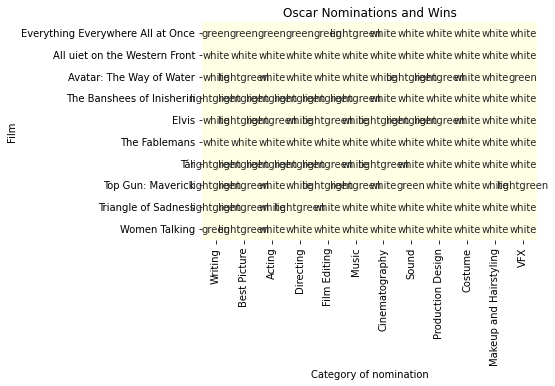

In [318]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary mapping values to colors
cmap = {'Not nominated': 'white', 'Nominated': 'lightgreen', 'Won': 'green'}

# Map the values in the dataframe to the corresponding colors
colors = nominations_df.applymap(lambda x: cmap[x])

# Create the heatmap using the mapped colors
sns.heatmap(nominations_df.isna().astype(int), annot=colors, fmt='', cmap='YlOrBr', cbar=False)

# Add labels and title to the plot
plt.xlabel('Category of nomination')
plt.ylabel('Film')
plt.title('Oscar Nominations and Wins')


In [274]:
# list of current noms
cats_soup = BeautifulSoup(rq.get('https://en.wikipedia.org/wiki/Academy_Awards').text, 'lxml')

# find all caption tags that contain the text 'Population'
caption_tag = cats_soup.find('caption', text=re.compile("List of current Awards of Merit categories by year introduced, sortable by category"))

cats_table = caption_tag.find_parent('table')
print(type(cats_table))
# use the pandas 'read_html()' function to convert the table to a DataFrame
cats_df = pd.read_html(str(cats_table))[0]
categories= cats_df['Category'].values
# print the DataFrame
print(categories)


<class 'bs4.element.Tag'>
['Best Picture' 'Best Director' 'Best Actor' 'Best Actress'
 'Best Cinematography' 'Best Production Design' 'Best Adapted Screenplay'
 'Best Sound' 'Best Animated Short Film' 'Best Live Action Short Film'
 'Best Film Editing' 'Best Original Score' 'Best Original Song'
 'Best Supporting Actor' 'Best Supporting Actress' 'Best Visual Effects'
 'Best Original Screenplay' 'Best Documentary Short Film'
 'Best Documentary Feature Film' 'Best International Feature Film'
 'Best Costume Design' 'Best Makeup and Hairstyling'
 'Best Animated Feature Film']


so oscar categories names changed throughout the years
honorary award is a separate to oscars award given by the board of governors - celbrates acheivements not covered by exisitng academy awards - im dleeting it